In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [4]:
train_loader = DataLoader(train_data, batch_size=1000, shuffle=True)
test_loader = DataLoader(test_data, batch_size = 1000, shuffle=True)

In [5]:
class Model(nn.Module):
    
    def __init__(self, hid_nodes):
        super().__init__()
        
        self.fc1 = nn.Linear(28*28, hid_nodes)
        self.out = nn.Linear(hid_nodes, 10)
        
    def forward(self, x):
        
        x = x.view(-1, 28*28)
        x = F.tanh(self.fc1(x))
        x = self.out(x)
        
        return F.log_softmax(x, dim=1)

In [6]:
def measurePredicted(pred_tens, target_tens):
    
    predicted = torch.max(pred_tens, 1)[1]
    
    corr = (predicted == target_tens).sum()
    
    return corr

In [7]:
def train_test(model, crit, opt, train_loader, test_loader):
    
    train_tot_loss = 0.0
    train_acc = 0.0
    num_corr = 0
    tot_loss = 0.0
        
    for _ , (images, targets) in enumerate(train_loader):
        
        model.zero_grad()
            
        pred = model(images)
            
        num_corr += measurePredicted(pred, targets)
            
        loss = crit(pred, targets)
        
        loss.backward()
        
        train_tot_loss += loss.item()
        
        opt.step()
            
    train_acc = num_corr / 60000
    
    test_tot_loss = 0.0
    test_acc = 0.0
    num_corr = 0
    
    for _ , (images, targets) in enumerate(test_loader):
        
        pred = model(images)
        
        test_tot_loss += crit(pred, targets).item()
        
        num_corr += measurePredicted(pred, targets)
        
    test_acc = num_corr/10000
            
    return train_tot_loss, test_tot_loss, train_acc, test_acc    
        

In [8]:
hid_nodes = [50,75,100,150,200,275,350,450,550,675]
param_list = []

for hn in hid_nodes:
    
    param_list.append(28*28*hn + hn + hn*10 + 10)

In [9]:
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list= []
crit = nn.CrossEntropyLoss()

for hn in hid_nodes:
    
    model = Model(hn)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_loss, test_loss, train_acc, test_acc = train_test(model, crit, optimizer, train_loader, test_loader)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

In [16]:
for ind in range(len(test_loss_list)):
    test_loss_list[ind] = 6*test_loss_list[ind]

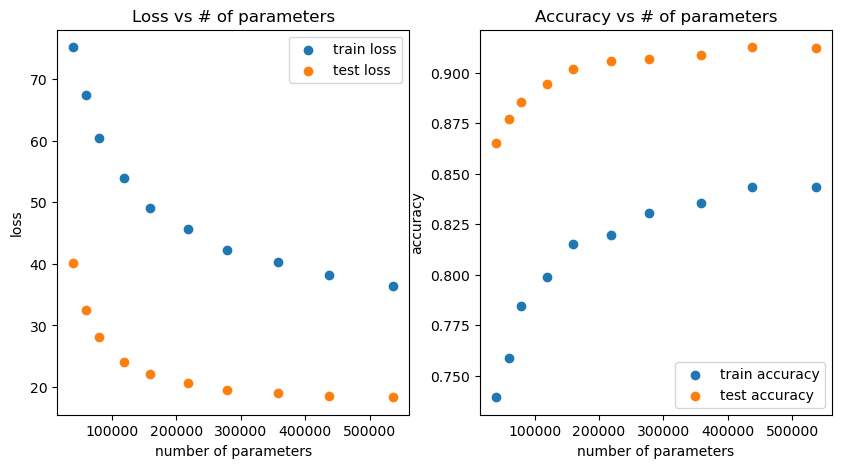

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
ax1.scatter(param_list, train_loss_list, label="train loss")
ax1.scatter(param_list, test_loss_list, label="test loss")
ax1.set_title("Loss vs # of parameters")
ax1.set_xlabel("number of parameters")
ax1.set_ylabel("loss")
ax1.legend()

ax2.scatter(param_list, train_acc_list, label="train accuracy")
ax2.scatter(param_list, test_acc_list, label="test accuracy")
ax2.set_title("Accuracy vs # of parameters")
ax2.set_xlabel("number of parameters")
ax2.set_ylabel("accuracy")
ax2.legend()
plt.show()